In [1]:
from src.model import GPT, GPTConfig
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
from Pennylane.Circuit_generate import QuantumEmbedding
from src.dataload import get_data
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torchvision
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data Loading

In [2]:
transform = torchvision.transforms.ToTensor()

# Download training data into data folder
training_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Download test data into data folder
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
# Get the training set features and labels
x_train = training_set.data
y_train = training_set.targets

# Get the test set features and labels
x_test = test_set.data
y_test = test_set.targets

# Rescale the images from [0, 255] to the [0, 1] range.
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Number of samples in the training set:", len(x_train))
print("Number of samples in the test set:", len(x_test))

Number of samples in the training set: 60000
Number of samples in the test set: 10000


In [4]:
# Use PCA to transform each image to an n-dimensional vector
n_components = 10

# Convert tensors to numpy arrays
x_train = x_train.numpy()
x_test = x_test.numpy()

# Number of train and test samples
num_train = x_train.shape[0]
num_test = x_test.shape[0]

# Flatten images to 1D arrays
x_train = np.reshape(x_train, (num_train, -1))
x_test = np.reshape(x_test, (num_test, -1))

# Run PCA
pca = PCA(n_components=n_components)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

# Normalize each feature in dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


print(f'New number of features per datapoint:', len(x_train[0]))

New number of features per datapoint: 10


## Hyperparameter Setting

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
n,p = x_train.shape

"""If use qubit matching, set num_qubits = p  otherwise, it is up to user's choice"""
num_qubits = 4
op_pool_size = p*4*num_qubits
max_gate = 12           # senario legth

# TensorDataset을 사용하여 데이터셋 생성
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int32).to(device)

X_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int32).to(device)

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

C:\Users\detra\AppData\Local\Temp\ipykernel_7092\342494363.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.int32).to(device)
C:\Users\detra\AppData\Local\Temp\ipykernel_7092\342494363.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.int32).to(device)


In [7]:
## Define quantum embedding circuit
dev = qml.device('default.qubit', wires=num_qubits)

@qml.qnode(dev, interface='torch')
def quantum_circuit(tokens, num_qubits, data):
    QuantumEmbedding(tokens, num_qubits, data)
    return qml.state()

In [8]:
def state_subsequnce(token, num_qubits, data_set):
    states = []
    for i in range(len(token)):
        if i ==0:
            pass
        else:
            sub_token = token[:i]
            for data in data_set:
                state = quantum_circuit(sub_token, num_qubits, data)
                states.append(state)
    return np.array(states).reshape(-1, data_set.shape[0], num_qubits**2)

In [9]:
def get_sub_energy(sub_states, labels):
    energies = []
    for states in sub_states:
        states_conj = np.conj(states)
        inner_prod = np.matmul(states_conj, states.T)
        fid_mat = np.abs(inner_prod)**2
        
        labels = labels.reshape(-1)
        label_prod = np.outer(labels, labels)

        loss_mat = (fid_mat - 0.5 * (1 + label_prod))**2
        indices = np.tril_indices(len(labels), k=1)
        loss_val = loss_mat[indices[0], indices[1]]
        loss = np.mean(loss_val)
        energies.append(loss)
    return np.array(energies)

In [10]:
def get_svm_acc(sub_states, labels, gamma):
    energies = []
    labels = labels.reshape(-1)
    for states in sub_states:
        states = np.hstack((states.real, states.imag))
        svm = SVC(kernel='rbf', gamma=gamma)
        svm.fit(states, labels)
        predict = svm.predict(states)
        acc = accuracy_score(predict, labels)
        energies.append(acc)

    return 1 - np.array(energies)

In [11]:
class GPTQE(GPT):
    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        return logits

    def calculate_loss(self, tokens, energies):
        current_tokens, next_tokens = tokens[:, :-1], tokens[:, 1:]
        # calculate the logits for the next possible tokens in the sequence
        logits = self(current_tokens)
        # get the logit for the actual next token in the sequence
        next_token_mask = torch.nn.functional.one_hot(
            next_tokens, num_classes=self.config.vocab_size
        )
        next_token_logits = (logits * next_token_mask).sum(axis=2)
        # calculate the cumulative logits for each subsequence
        cumsum_logits = torch.cumsum(next_token_logits, dim=1)
        # match cumulative logits to subsequence energies
        loss = torch.mean(torch.square(cumsum_logits - energies))
        return loss

    @torch.no_grad()
    def generate(self, n_sequences, max_new_tokens, temperature=1.0, device="cpu"):
        idx = torch.zeros(size=(n_sequences, 1), dtype=int, device=device)
        total_logits = torch.zeros(size=(n_sequences, 1), device=device)
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits = self(idx_cond)
            # pluck the logits at the final step
            logits = logits[:, -1, :]
            # set the logit of the first token so that its probability will be zero
            logits[:, 0] = float("inf")
            # apply softmax to convert logits to (normalized) probabilities and scale by desired temperature
            probs = F.softmax(-logits / temperature, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # # Accumulate logits
            total_logits += torch.gather(logits, index=idx_next, dim=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, total_logits

In [12]:
gpt = GPTQE(GPTConfig(
    vocab_size = op_pool_size + 1,
    block_size = max_gate,
    dropout = 0.2,
    bias = False
))
opt = gpt.configure_optimizers(
    weight_decay=0.1, learning_rate=1e-9, betas=(0.9, 0.999), device_type="cpu"
)

number of parameters: 85.08M
num decayed parameter tensors: 50, with 85,067,520 parameters
num non-decayed parameter tensors: 25, with 19,200 parameters
using fused AdamW: False


In [13]:
EPOCHS = 100
TEM = 1
R = 0.999
GAMMA = 1

train_losses = []
fid_losses = []

In [15]:
for i in range(EPOCHS):
    for X, Y in train_loader:
        Y = Y.detach().numpy()
        token, _ = gpt.generate(1, max_gate, TEM)
        states = state_subsequnce(*token, num_qubits, X)
        energy = get_svm_acc(states, Y, GAMMA) - 1
        energy_ten = torch.tensor(energy[None,:])
        loss = gpt.calculate_loss(token, energy_ten)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())

        ev_tok, _ = gpt.generate(1, max_gate, 0.00001)
        ev_states = state_subsequnce(*ev_tok, num_qubits, X)
        energy = get_svm_acc(ev_states, Y, GAMMA)[-1]
        fid_losses.append(energy)
        print(f"Epochs: {i+1},  Loss : {loss.item():.4f}, Fid loss : {energy}")
    
    

    TEM = TEM * R

Epochs: 1,  Loss : 13.6074, Fid loss : 0.234375
Epochs: 1,  Loss : 0.4335, Fid loss : 0.265625
Epochs: 1,  Loss : 4.3322, Fid loss : 0.203125
Epochs: 1,  Loss : 2.6888, Fid loss : 0.203125
Epochs: 1,  Loss : 6.3409, Fid loss : 0.234375
Epochs: 1,  Loss : 0.3068, Fid loss : 0.3125
Epochs: 1,  Loss : 6.0140, Fid loss : 0.328125
Epochs: 1,  Loss : 0.3331, Fid loss : 0.296875
Epochs: 1,  Loss : 1.8564, Fid loss : 0.296875
Epochs: 1,  Loss : 1.8991, Fid loss : 0.34375
Epochs: 1,  Loss : 0.9712, Fid loss : 0.265625
Epochs: 1,  Loss : 0.9872, Fid loss : 0.125
Epochs: 1,  Loss : 4.6913, Fid loss : 0.078125
Epochs: 1,  Loss : 1.9300, Fid loss : 0.3125
Epochs: 1,  Loss : 0.2367, Fid loss : 0.1875
Epochs: 1,  Loss : 0.8925, Fid loss : 0.265625
Epochs: 1,  Loss : 0.7699, Fid loss : 0.359375
Epochs: 1,  Loss : 3.0982, Fid loss : 0.21875
Epochs: 1,  Loss : 2.5737, Fid loss : 0.25
Epochs: 1,  Loss : 0.0911, Fid loss : 0.171875
Epochs: 1,  Loss : 0.2072, Fid loss : 0.421875
Epochs: 1,  Loss : 0.5996, 

KeyboardInterrupt: 

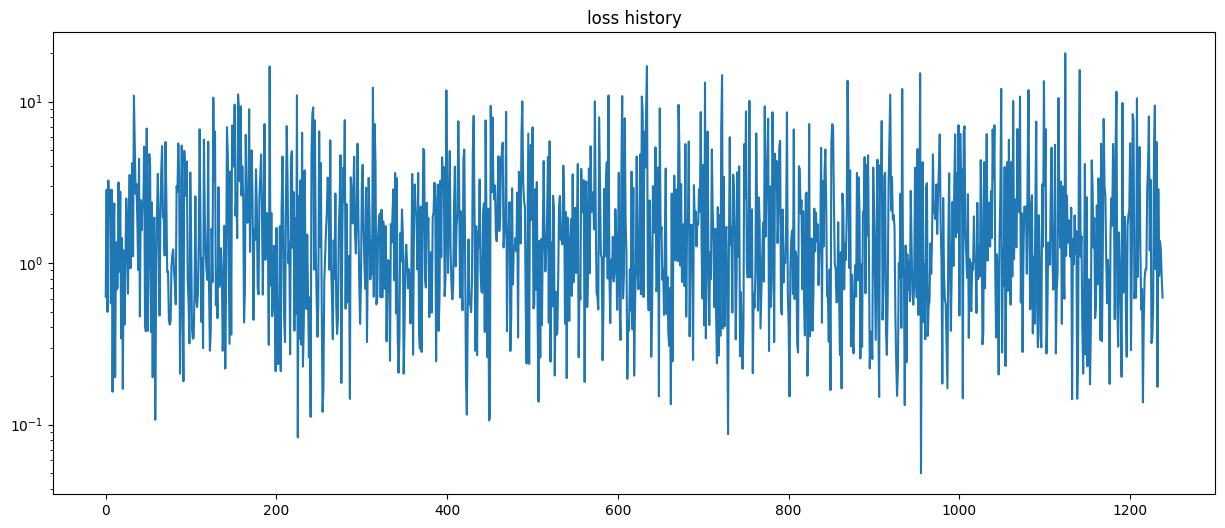

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(train_losses)
plt.title("loss history")
plt.yscale("log")

Text(0.5, 1.0, 'training fidelity loss')

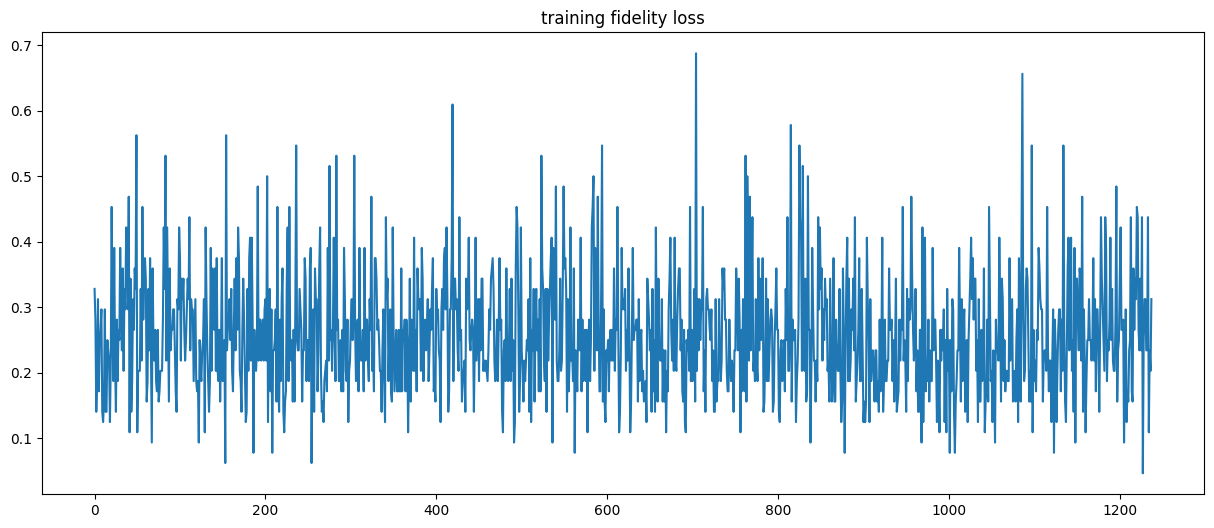

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(fid_losses)
plt.title("training fidelity loss")

Text(0.5, 1.0, 'evaluation loss')

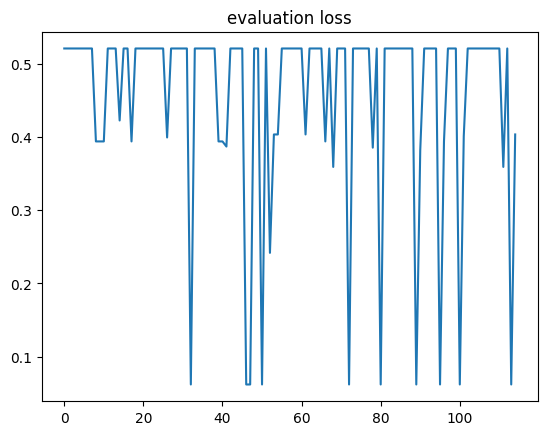

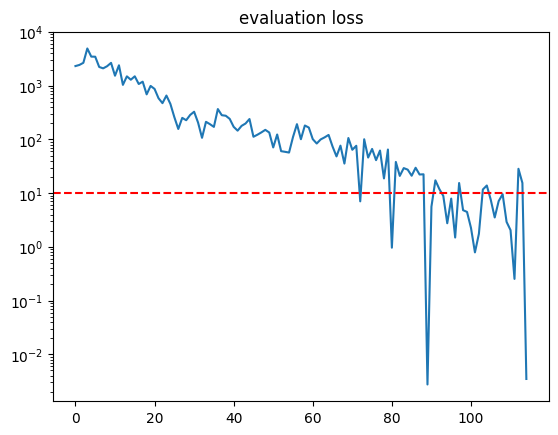

In [ ]:
plt.yscale('log')
plt.plot(ev_loss_history)
plt.title("evaluation loss")
plt.axhline(10, c='r', linestyle='--')

In [ ]:
final_token, logit = model.token_generate(max_new_tokens = max_gate, temperature = .01, device = device)

In [ ]:
from Qiskit.Circuit_generate import circuit_generator, get_tr_dist_matrix, get_fid_matrix, calculate_fidelity
c, _ = circuit_generator(final_token[0], n_qubits=num_qubits, data=X_batch[0], matching=False)

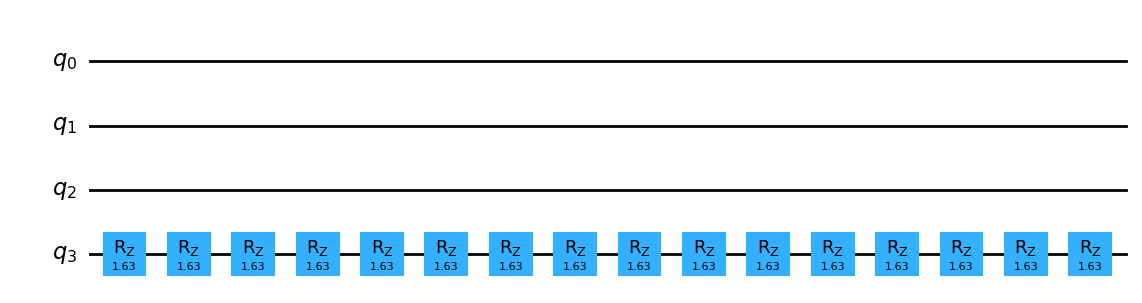

In [ ]:
c.draw('mpl')